In [1]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import average_precision_score

np.random.seed(2019)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import lightgbm as lgb

In [2]:
import plotly
import plotly.graph_objs as go
import cufflinks as cf
cf.set_config_file(offline=True)

In [3]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
sys.path.append(strategy_path)

In [4]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

In [5]:
from models.CRNN import CRNN_model

In [6]:
strategy = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy.load_index_and_return(from_db=False, save_file=False)

strategy.index.columns.name = 'ticker'
strategy.ret.columns.name = 'ticker'

strategy.index.index.name = 'tdate'
strategy.ret.index.name = 'tdate'

strategy.index.drop_duplicates(inplace=True)
strategy.ret.drop_duplicates(inplace=True)

df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

2019-11-21 16:39:08,856 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:39:08,858 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:39:08,859 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


# 3. Model

### CROSS SECTIONAL

In [7]:
indiv_momentum_lst = [5, 10, 21, 42, 63, 126, 252]

## 1. X

### moving average 와 주가 차이

In [8]:
moving_avg = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg['moving_average_' + str(period)] = df_index.rolling(period).mean() - df_index

### moving average  ratio

In [9]:
moving_avg_ratio = {}
moving_avg_ratio_diff = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg_ratio['moving_average_ratio_' + str(period)] = df_index.rolling(period).mean() / df_index
    moving_avg_ratio_diff['moving_average_ratio_diff_' + str(period)] = moving_avg_ratio['moving_average_ratio_' + str(period)].diff(period)

In [10]:
df_moving_avg = pd.concat(moving_avg, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio = pd.concat(moving_avg_ratio, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio_diff = pd.concat(moving_avg_ratio_diff, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]

### moving average ratio 간 차이

In [11]:
moving_avg_columns = df_moving_avg_ratio.columns

for i, column1 in enumerate(moving_avg_columns[1:]):
    for j, column2 in enumerate(moving_avg_columns[2+i:]):
        df_moving_avg_ratio[column2 + " - " + column1] = df_moving_avg_ratio[column1] - df_moving_avg_ratio[column2]

- 빨간색이 CROSS SECTIONAL 임

# CASE 0 기존

In [12]:
from EPM import EPM

In [13]:
epm = EPM(strategy_name="EPM", asset_type="EQUITY")
epm.load_index_and_return(from_db=False, save_file=False)
epm.load_strategy_data(table='datastream', origin='EPS')
epm.set_rebalance_period(freq='month')  # rebalance_day: monday = 0, sunday = 6
epm.calculate_signal(minobs1=52, longlen=52, longlen2=13, shortlen=2, cs=0.35)
epm.set_portfolio_parameter(cs_strategy_type='notional')
epm.make_portfolio()

2019-11-21 16:39:09,106 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:39:09,106 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:39:09,108 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:39:09,108 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:39:09,109 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:39:09,109 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:39:10,153 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:39:10,153 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:39:10,154 - EPM - INFO - [STEP 3] CACULATE SIGNAL
2019-11-21 16:39:10,154 - EPM - INFO - [STEP 3] CACULATE SIGNAL
2019-11-21 16:39:10,155 - EPM - INFO - [STEP 3 - 1 - 1] SIGNAL 1. LONG TERM MOMENTUM
2019-11-21 16:39:10,155 - EPM - INFO - [STEP 3 - 1 - 1] SIGNAL 1. LONG TERM MOMENTUM
2019-11-21 16:39:10,189 - EPM - INFO - [STEP 3 - 1 - 2] SIGNAL 2. LONG TERM MOMENTUM - PERCENTAGE OF UP DAYS
2019-11-21 16:39:10,189 - EPM - INFO - [STEP 3 - 1 - 2] SIGNAL 

In [14]:
start_date = '2011-01-01'
end_date = '2018-05-09'

# get r results
epm_comp_df = pd.read_csv('../check/past/epm.csv', header=0, index_col=0, parse_dates=True)
epm_lag_comp_df = pd.read_csv('../check/past/epm_lag.csv', header=0, index_col=0, parse_dates=True)

In [15]:
tester = Tester(epm)
tester.set_period(start=start_date, end=end_date)
tester.run()

2019-11-21 16:39:34,895 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:39:34,895 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:39:34,896 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:39:34,896 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:39:35,737 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-11-21 16:39:35,737 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL


In [16]:
to_plot = (1.+ epm_comp_df).loc[start_date:].cumprod()
to_plot['TS_python'] = tester.strategy.TS_result
to_plot['CS_python'] = tester.strategy.CS_result
to_plot.iplot()

# CASE 1. BINARY

- Binary로 나누어서 학습하고 상위 30% 하위 30% 롱숏

In [17]:
one_month = 20
df_index_rank = df_index.pct_change(one_month).shift(-1 * one_month).rank(axis=1) 
df_index_y_binary = df_index_rank > df_index_rank.shape[1] / 2
df_index_y_binary = df_index_y_binary.astype(np.float32)

In [18]:
df_y = df_index_y_binary.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [19]:
df_moving_avg.reset_index(inplace=True)
df_moving_avg_ratio.reset_index(inplace=True)

df_join = pd.merge(df_y, df_moving_avg_ratio, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_moving_avg_ratio_diff, on=['tdate', 'ticker'])

df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime('2007-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2008-01-01')) & (df_join['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [20]:
def train_tree(train_x, train_y1, val_x, val_y1, max_depth=7, fraction=0.8, num_leaves=50, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, random_state=1, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': max_depth,
          'num_leaves': num_leaves,
          "learning_rate": learning_rate,
          "feature_fraction": fraction,
          "subsample": fraction,
          "verbosity": verbose,
          "metric": 'binary_logloss',
          'random_state': random_state
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [21]:
model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=i+1)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.692944	valid_1's binary_logloss: 0.693126
[20]	training's binary_logloss: 0.692745	valid_1's binary_logloss: 0.693098
[30]	training's binary_logloss: 0.692549	valid_1's binary_logloss: 0.693077
[40]	training's binary_logloss: 0.692352	valid_1's binary_logloss: 0.693034
[50]	training's binary_logloss: 0.692162	valid_1's binary_logloss: 0.693006
[60]	training's binary_logloss: 0.691967	valid_1's binary_logloss: 0.692985
[70]	training's binary_logloss: 0.691772	valid_1's binary_logloss: 0.692966
[80]	training's binary_logloss: 0.691579	valid_1's binary_logloss: 0.692955
[90]	training's binary_logloss: 0.691401	valid_1's binary_logloss: 0.692932
[100]	training's binary_logloss: 0.691222	valid_1's binary_logloss: 0.692916
[110]	training's binary_logloss: 0.691037	valid_1's binary_logloss: 0.692902
[120]	training's binary_logloss: 0.69085	valid_1's binary_logloss: 0.692885
[130]	training's binary_

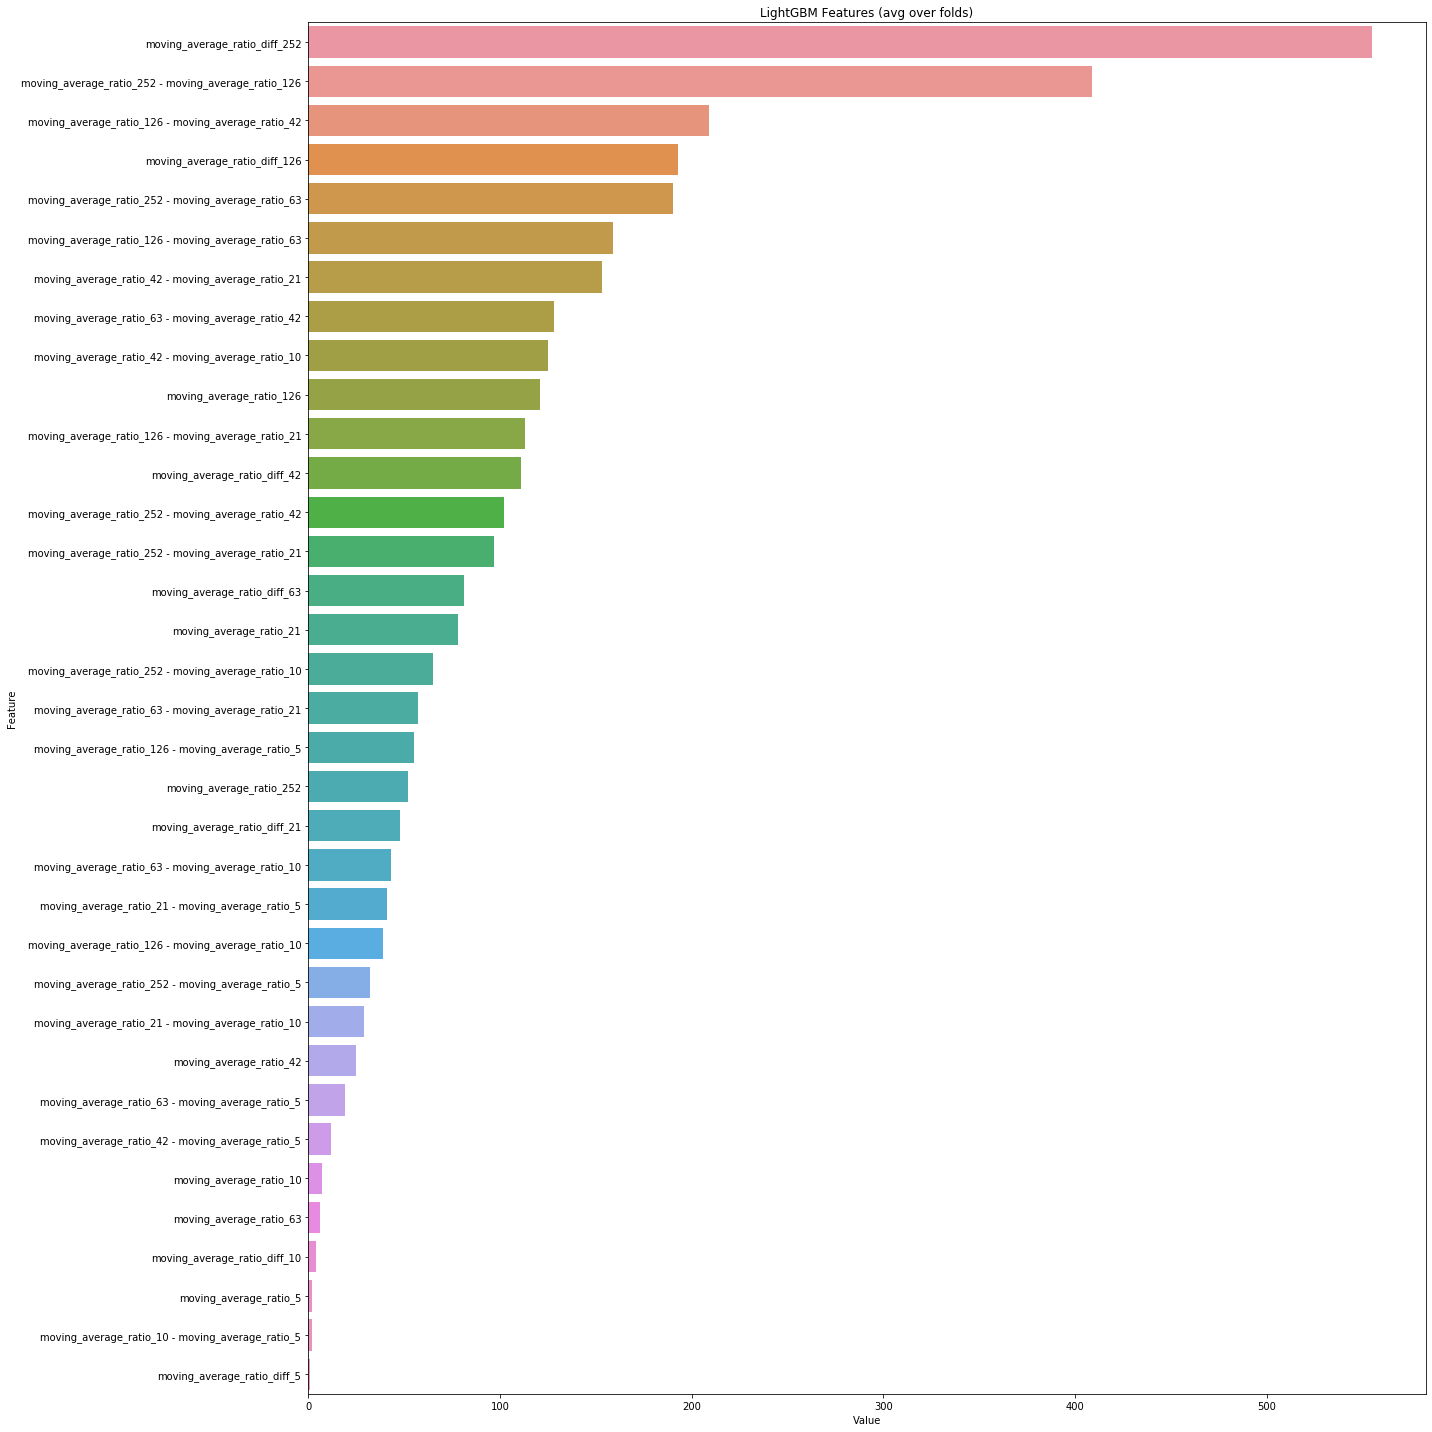

In [22]:
supply_demand_feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), df_train.columns[3:])), columns=['Value','Feature'])
plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=supply_demand_feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [23]:
test_pred = model.predict(df_test_x.values)

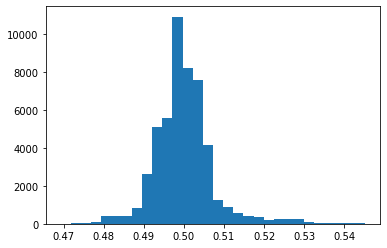

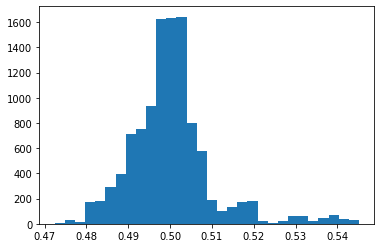

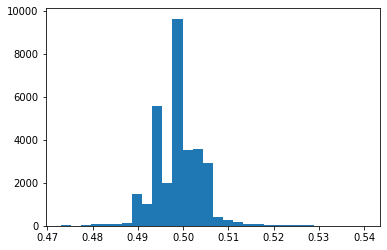

In [24]:
plt.hist(train_pred, bins=30)
plt.show()

plt.hist(val_pred, bins=30)
plt.show()

plt.hist(test_pred, bins=30)
plt.show()

### 결과

In [25]:
df_train['y_pred'] = train_pred
df_val['y_pred'] = val_pred
df_test['y_pred'] = test_pred
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_val_pred = pd.pivot_table(df_val, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')
df_pred = pd.concat([df_train_pred, df_val_pred, df_test_pred], axis=0)

In [26]:
df_index_sub = df_index.loc['1994':]
long = df_pred.shape[1] / 10 * 7
short = df_pred.shape[1] / 10 * 3

df_pred_rank = df_pred.rank(axis=1)
df_pred_long = (df_pred_rank > long).astype(np.float32)
df_pred_short = (df_pred_rank < short).astype(np.float32)
df_pred_long_short = df_pred_long - df_pred_short
strategy.TSRV = df_pred_long_short
strategy.CSRV = df_pred_long_short

In [27]:
strategy.set_rebalance_period(freq='month')
tester = Tester(strategy)
strategy.set_portfolio_parameter(cs_strategy_type='notional')
strategy.make_portfolio()

2019-11-21 16:39:39,454 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:39:39,454 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:39:39,455 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:39:39,455 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:39:39,455 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-21 16:39:39,455 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-21 16:39:39,456 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-11-21 16:39:39,456 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-11-21 16:39:54,322 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-11-21 16:39:54,322 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-11-21 16:39:54,324 - EPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-11-21 16:39:54,324 - EPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-11-21 16:39:56,775 - EPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-11-21 16:39:56,775 - EPM - 

In [28]:
tester1 = Tester(strategy)
tester1.set_period(start=start_date, end=end_date)
tester1.run()

2019-11-21 16:40:04,370 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:40:04,370 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:40:04,371 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:40:04,371 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:40:04,979 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-11-21 16:40:04,979 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL


In [29]:
to_plot['CS_ML'] = tester1.strategy.CS_result

In [30]:
to_plot.iplot()

# CASE 2. BINARY 30% 70%


- 상위 30%에 속하는 데이터와 하위 30%에 속하는 데이터로 학습한다.

In [31]:
df_index_y_binary1 = df_index_rank > df_index_rank.shape[1] / 4 * 3
df_index_y_binary1 = df_index_y_binary1.astype(np.float32)
df_y = df_index_y_binary1.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [32]:
df_join2 = pd.merge(df_y, df_moving_avg_ratio, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_moving_avg_ratio_diff, on=['tdate', 'ticker'])

df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime('2007-12-31')]
df_val = df_join2.loc[(df_join2['tdate'] >= pd.to_datetime('2008-01-01')) & (df_join2['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join2.loc[df_join2['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [33]:
model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=i+1)

Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.598049	valid_1's binary_logloss: 0.598168
[20]	training's binary_logloss: 0.597838	valid_1's binary_logloss: 0.598056
[30]	training's binary_logloss: 0.597627	valid_1's binary_logloss: 0.597959
[40]	training's binary_logloss: 0.59742	valid_1's binary_logloss: 0.597845
[50]	training's binary_logloss: 0.597217	valid_1's binary_logloss: 0.597748
[60]	training's binary_logloss: 0.597016	valid_1's binary_logloss: 0.597676
[70]	training's binary_logloss: 0.596815	valid_1's binary_logloss: 0.597589
[80]	training's binary_logloss: 0.59662	valid_1's binary_logloss: 0.597513
[90]	training's binary_logloss: 0.596431	valid_1's binary_logloss: 0.597432
[100]	training's binary_logloss: 0.596242	valid_1's binary_logloss: 0.59735
[110]	training's binary_logloss: 0.596048	valid_1's binary_logloss: 0.597291
[120]	training's binary_logloss: 0.59586	valid_1's binary_logloss: 0.597222
[130]	training's binary_log

In [34]:
test_pred = model.predict(df_test_x.values)

In [35]:
df_train['y_pred'] = train_pred
df_val['y_pred'] = val_pred
df_test['y_pred'] = test_pred
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_val_pred = pd.pivot_table(df_val, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')

df_pred2 = pd.concat([df_train_pred, df_val_pred, df_test_pred], axis=0)

In [36]:
long = df_pred2.shape[1] / 10 * 7
short = df_pred2.shape[1] / 10 * 3
df_pred_rank2 = df_pred2.rank(axis=1)
df_pred_long2 = (df_pred_rank2 > long).astype(np.float32)
df_pred_short2 = (df_pred_rank2 < short).astype(np.float32)
df_pred_long_short2 = df_pred_long2 - df_pred_short2

In [37]:
strategy2 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy2.load_index_and_return(from_db=False, save_file=False)
strategy2.TSRV = df_pred_long_short2
strategy2.CSRV = df_pred_long_short2
strategy2.set_rebalance_period(freq='month') 
strategy2.set_portfolio_parameter(cs_strategy_type='notional')
strategy2.make_portfolio()

2019-11-21 16:40:07,699 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:40:07,699 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:40:07,699 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:40:07,701 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:40:07,701 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:40:07,701 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:40:07,703 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:40:07,703 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:40:07,703 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:40:07,750 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:40:07,750 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:40:07,750 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:40:07,751 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:40:07,751 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:40:07,751 - EPM - INFO - [STEP 4] SET PORTFOLIO

In [38]:
tester2 = Tester(strategy2)
tester2.set_period(start=start_date, end=end_date)
tester2.run()

2019-11-21 16:40:32,529 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:40:32,529 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:40:32,529 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:40:32,530 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:40:32,530 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:40:32,530 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:40:33,167 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-11-21 16:40:33,167 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-11-21 16:40:33,167 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL


In [39]:
to_plot['CS_ML_UPPER'] = tester2.strategy.CS_result

In [40]:
to_plot.iplot()

In [41]:
result = pd.concat([epm.CS_summary,
                    epm.TS_summary,
                    strategy.CS_summary,
                    strategy2.CS_summary], axis=1)

In [42]:
result

0         1         2         3
TURNOVER   2.175536  0.834014  3.016115  2.877425
MDD       -0.028668 -0.040567 -0.039339 -0.032543
CAGR       0.007017  0.002591  0.002950  0.008462
CAGR_TR   -0.003191 -0.000753 -0.009359 -0.005272
VOL        0.001356  0.001196  0.001386  0.001339
SHARPE     0.329635  0.143223  0.142404  0.399710
SHARPE_TR -0.134812 -0.029428 -0.408026 -0.232812

In [43]:
result.columns = ['CS_python', 'TS_python', 'CS_ML', 'CS_ML_UPPER']

In [44]:
result

CS_python  TS_python     CS_ML  CS_ML_UPPER
TURNOVER    2.175536   0.834014  3.016115     2.877425
MDD        -0.028668  -0.040567 -0.039339    -0.032543
CAGR        0.007017   0.002591  0.002950     0.008462
CAGR_TR    -0.003191  -0.000753 -0.009359    -0.005272
VOL         0.001356   0.001196  0.001386     0.001339
SHARPE      0.329635   0.143223  0.142404     0.399710
SHARPE_TR  -0.134812  -0.029428 -0.408026    -0.232812

# CASE 3. Case1을 Rolling으로 실행

In [45]:
val_rolling_one_year = ['2007-12-31',
                    '2008-12-31',
                    '2009-12-31',
                    '2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31']

In [46]:
test_rolling_one_year = ['2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31',
                    '2016-12-31',
                    '2017-12-31',
                    '2018-12-31']

In [47]:
models = []
train_preds = []
val_preds = []
test_preds = []

In [48]:
for i, one_year in enumerate(val_rolling_one_year):
    df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime(val_rolling_one_year[i])]
    
    if i == len(val_rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(test_rolling_one_year[i])]
        df_val = df_join.loc[(df_join['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                     (df_join['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
    else:
        df_val = df_join.loc[(df_join['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                             (df_join['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
        
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(test_rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(test_rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]
    
    df_val_y = df_val['y']
    df_val_x = df_val[df_val.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=0)
    test_pred = model.predict(df_test_x.values)
    df_train['y_pred'] = train_pred
    df_val['y_pred'] = val_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    val_preds.append(df_val)
    test_preds.append(df_test)

Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.692942	valid_1's binary_logloss: 0.693126
[20]	training's binary_logloss: 0.692734	valid_1's binary_logloss: 0.693105
[30]	training's binary_logloss: 0.692522	valid_1's binary_logloss: 0.693093
[40]	training's binary_logloss: 0.692331	valid_1's binary_logloss: 0.693066
[50]	training's binary_logloss: 0.692134	valid_1's binary_logloss: 0.693031
[60]	training's binary_logloss: 0.691938	valid_1's binary_logloss: 0.693021
[70]	training's binary_logloss: 0.691741	valid_1's binary_logloss: 0.693002
[80]	training's binary_logloss: 0.691554	valid_1's binary_logloss: 0.692993
[90]	training's binary_logloss: 0.691361	valid_1's binary_logloss: 0.692982
[100]	training's binary_logloss: 0.691186	valid_1's binary_logloss: 0.692974
[110]	training's binary_logloss: 0.69101	valid_1's binary_logloss: 0.692959
[120]	training's binary_logloss: 0.690825	valid_1's binary_logloss: 0.692935
[130]	training's binary_

[160]	training's binary_logloss: 0.690966	valid_1's binary_logloss: 0.692974
[170]	training's binary_logloss: 0.690834	valid_1's binary_logloss: 0.692963
[180]	training's binary_logloss: 0.690701	valid_1's binary_logloss: 0.692958
[190]	training's binary_logloss: 0.690581	valid_1's binary_logloss: 0.692953
[200]	training's binary_logloss: 0.690455	valid_1's binary_logloss: 0.692951
[210]	training's binary_logloss: 0.690328	valid_1's binary_logloss: 0.692952
[220]	training's binary_logloss: 0.690211	valid_1's binary_logloss: 0.692948
[230]	training's binary_logloss: 0.690094	valid_1's binary_logloss: 0.692941
[240]	training's binary_logloss: 0.689973	valid_1's binary_logloss: 0.692942
[250]	training's binary_logloss: 0.689853	valid_1's binary_logloss: 0.692938
[260]	training's binary_logloss: 0.689739	valid_1's binary_logloss: 0.692936
[270]	training's binary_logloss: 0.689619	valid_1's binary_logloss: 0.692929
[280]	training's binary_logloss: 0.689499	valid_1's binary_logloss: 0.692924

[80]	training's binary_logloss: 0.692162	valid_1's binary_logloss: 0.693286
[90]	training's binary_logloss: 0.692047	valid_1's binary_logloss: 0.693297
[100]	training's binary_logloss: 0.691933	valid_1's binary_logloss: 0.693303
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.693134	valid_1's binary_logloss: 0.693153
Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.693024	valid_1's binary_logloss: 0.693178
[20]	training's binary_logloss: 0.692906	valid_1's binary_logloss: 0.693183
[30]	training's binary_logloss: 0.692783	valid_1's binary_logloss: 0.693203
[40]	training's binary_logloss: 0.692666	valid_1's binary_logloss: 0.693233
[50]	training's binary_logloss: 0.692549	valid_1's binary_logloss: 0.693265
[60]	training's binary_logloss: 0.692431	valid_1's binary_logloss: 0.693289
[70]	training's binary_logloss: 0.692312	valid_1's binary_logloss: 0.693305
[80]	training's binary_logloss: 0.692201	valid_1's binary_logloss: 

In [49]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

In [50]:
long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

df_pred_rank3 = df_test_pred.rank(axis=1)
df_pred_long3 = (df_pred_rank3 > long).astype(np.float32)
df_pred_short3 = (df_pred_rank3 < short).astype(np.float32)
df_pred_long_short3 = df_pred_long3 - df_pred_short3

In [51]:
strategy3 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy3.load_index_and_return(from_db=False, save_file=False)
strategy3.index.drop_duplicates(inplace=True)
strategy3.ret.drop_duplicates(inplace=True)

2019-11-21 16:40:42,230 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:40:42,230 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:40:42,230 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:40:42,230 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:40:42,233 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:40:42,233 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:40:42,233 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:40:42,233 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:40:42,236 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:40:42,236 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:40:42,236 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:40:42,236 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [52]:
strategy3.TSRV = df_pred_long_short3
strategy3.CSRV = df_pred_long_short3

strategy3.set_rebalance_period(freq='month') 
strategy3.set_portfolio_parameter(cs_strategy_type='notional')
strategy3.make_portfolio()

2019-11-21 16:40:42,300 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:40:42,300 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:40:42,300 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:40:42,300 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:40:42,301 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:40:42,301 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:40:42,301 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:40:42,301 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:40:42,303 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-21 16:40:42,303 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-21 16:40:42,303 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-21 16:40:42,303 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-21 16:40:42,304 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-11-21 16:40:42,304 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-11-21 16:40:42,304 - EPM - INFO -

In [53]:
tester3 = Tester(strategy3)
tester3.set_period(start=start_date, end=end_date)
tester3.run()

2019-11-21 16:41:00,186 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:41:00,186 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:41:00,186 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:41:00,186 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:41:00,187 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:41:00,187 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:41:00,187 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:41:00,187 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:41:00,731 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-11-21 16:41:00,731 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-11-21 16:41:00,731 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-11-21 16:41:00,731 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL


In [54]:
to_plot['CS_ML_ROLLING'] = tester3.strategy.CS_result

In [55]:
to_plot.iplot()

In [56]:
result = pd.concat([epm.CS_summary,
                    epm.TS_summary,
                    strategy.CS_summary,
                    strategy2.CS_summary,
                    strategy3.CS_summary], axis=1)

In [57]:
result.columns = ['CS_python', 'TS_python', 'CS_ML', 'CS_ML_UPPER', 'CS_ML_ROLLING']

In [58]:
result

CS_python  TS_python     CS_ML  CS_ML_UPPER  CS_ML_ROLLING
TURNOVER    2.175536   0.834014  3.016115     2.877425       2.789747
MDD        -0.028668  -0.040567 -0.039339    -0.032543      -0.037296
CAGR        0.007017   0.002591  0.002950     0.008462       0.003097
CAGR_TR    -0.003191  -0.000753 -0.009359    -0.005272      -0.008596
VOL         0.001356   0.001196  0.001386     0.001339       0.001361
SHARPE      0.329635   0.143223  0.142404     0.399710       0.151228
SHARPE_TR  -0.134812  -0.029428 -0.408026    -0.232812      -0.380727

# CASE 4. CASE 2를 ROLLING으로 실행

In [59]:
models = []
train_preds = []
val_preds = []
test_preds = []

In [60]:
for i, one_year in enumerate(val_rolling_one_year):
    df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime(val_rolling_one_year[i])]
    
    if i == len(val_rolling_one_year) - 1:
        df_test = df_join2.loc[df_join2['tdate'] > pd.to_datetime(test_rolling_one_year[i])]
        df_val = df_join2.loc[(df_join2['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                     (df_join2['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
    else:
        df_val = df_join2.loc[(df_join2['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                             (df_join2['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
        
        df_test = df_join2.loc[(df_join2['tdate'] <= pd.to_datetime(test_rolling_one_year[i+1])) & 
                              (df_join2['tdate'] > pd.to_datetime(test_rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]
    
    df_val_y = df_val['y']
    df_val_x = df_val[df_val.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=0)
    test_pred = model.predict(df_test_x.values)
    df_train['y_pred'] = train_pred
    df_val['y_pred'] = val_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    val_preds.append(df_val)
    test_preds.append(df_test)

Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.598053	valid_1's binary_logloss: 0.59814
[20]	training's binary_logloss: 0.597834	valid_1's binary_logloss: 0.598015
[30]	training's binary_logloss: 0.597615	valid_1's binary_logloss: 0.597893
[40]	training's binary_logloss: 0.597405	valid_1's binary_logloss: 0.597794
[50]	training's binary_logloss: 0.597197	valid_1's binary_logloss: 0.597701
[60]	training's binary_logloss: 0.596989	valid_1's binary_logloss: 0.597612
[70]	training's binary_logloss: 0.596789	valid_1's binary_logloss: 0.597536
[80]	training's binary_logloss: 0.596593	valid_1's binary_logloss: 0.597465
[90]	training's binary_logloss: 0.596395	valid_1's binary_logloss: 0.597393
[100]	training's binary_logloss: 0.596208	valid_1's binary_logloss: 0.597341
[110]	training's binary_logloss: 0.596023	valid_1's binary_logloss: 0.597287
[120]	training's binary_logloss: 0.595837	valid_1's binary_logloss: 0.59722
[130]	training's binary_l

[290]	training's binary_logloss: 0.593658	valid_1's binary_logloss: 0.598059
[300]	training's binary_logloss: 0.593524	valid_1's binary_logloss: 0.59806
[310]	training's binary_logloss: 0.593389	valid_1's binary_logloss: 0.598061
[320]	training's binary_logloss: 0.593258	valid_1's binary_logloss: 0.598061
[330]	training's binary_logloss: 0.593122	valid_1's binary_logloss: 0.598059
[340]	training's binary_logloss: 0.592993	valid_1's binary_logloss: 0.598057
[350]	training's binary_logloss: 0.592867	valid_1's binary_logloss: 0.598054
[360]	training's binary_logloss: 0.592745	valid_1's binary_logloss: 0.598048
[370]	training's binary_logloss: 0.592617	valid_1's binary_logloss: 0.598049
[380]	training's binary_logloss: 0.592495	valid_1's binary_logloss: 0.598045
[390]	training's binary_logloss: 0.592371	valid_1's binary_logloss: 0.59805
[400]	training's binary_logloss: 0.59225	valid_1's binary_logloss: 0.59805
[410]	training's binary_logloss: 0.592131	valid_1's binary_logloss: 0.598046
[42

[900]	training's binary_logloss: 0.588225	valid_1's binary_logloss: 0.596303
[910]	training's binary_logloss: 0.58815	valid_1's binary_logloss: 0.596295
[920]	training's binary_logloss: 0.588067	valid_1's binary_logloss: 0.59628
[930]	training's binary_logloss: 0.587993	valid_1's binary_logloss: 0.59626
[940]	training's binary_logloss: 0.58791	valid_1's binary_logloss: 0.59625
[950]	training's binary_logloss: 0.587832	valid_1's binary_logloss: 0.59624
[960]	training's binary_logloss: 0.587751	valid_1's binary_logloss: 0.596232
[970]	training's binary_logloss: 0.587675	valid_1's binary_logloss: 0.596225
[980]	training's binary_logloss: 0.587604	valid_1's binary_logloss: 0.596206
[990]	training's binary_logloss: 0.58753	valid_1's binary_logloss: 0.596193
[1000]	training's binary_logloss: 0.587448	valid_1's binary_logloss: 0.59618
[1010]	training's binary_logloss: 0.587374	valid_1's binary_logloss: 0.596166
[1020]	training's binary_logloss: 0.587295	valid_1's binary_logloss: 0.596155
[103

[210]	training's binary_logloss: 0.595154	valid_1's binary_logloss: 0.597756
[220]	training's binary_logloss: 0.595032	valid_1's binary_logloss: 0.597737
[230]	training's binary_logloss: 0.594905	valid_1's binary_logloss: 0.597722
[240]	training's binary_logloss: 0.594775	valid_1's binary_logloss: 0.597696
[250]	training's binary_logloss: 0.594652	valid_1's binary_logloss: 0.597667
[260]	training's binary_logloss: 0.594529	valid_1's binary_logloss: 0.597651
[270]	training's binary_logloss: 0.594406	valid_1's binary_logloss: 0.597625
[280]	training's binary_logloss: 0.594285	valid_1's binary_logloss: 0.597608
[290]	training's binary_logloss: 0.594162	valid_1's binary_logloss: 0.597588
[300]	training's binary_logloss: 0.594042	valid_1's binary_logloss: 0.597575
[310]	training's binary_logloss: 0.593924	valid_1's binary_logloss: 0.597561
[320]	training's binary_logloss: 0.593809	valid_1's binary_logloss: 0.59755
[330]	training's binary_logloss: 0.593691	valid_1's binary_logloss: 0.597533


[1270]	training's binary_logloss: 0.585928	valid_1's binary_logloss: 0.596782
[1280]	training's binary_logloss: 0.585863	valid_1's binary_logloss: 0.596779
[1290]	training's binary_logloss: 0.585796	valid_1's binary_logloss: 0.596779
[1300]	training's binary_logloss: 0.585728	valid_1's binary_logloss: 0.596779
[1310]	training's binary_logloss: 0.585664	valid_1's binary_logloss: 0.596775
[1320]	training's binary_logloss: 0.585602	valid_1's binary_logloss: 0.596767
[1330]	training's binary_logloss: 0.585539	valid_1's binary_logloss: 0.596768
[1340]	training's binary_logloss: 0.585471	valid_1's binary_logloss: 0.596766
[1350]	training's binary_logloss: 0.585403	valid_1's binary_logloss: 0.59676
[1360]	training's binary_logloss: 0.585332	valid_1's binary_logloss: 0.596754
[1370]	training's binary_logloss: 0.585267	valid_1's binary_logloss: 0.596753
[1380]	training's binary_logloss: 0.585199	valid_1's binary_logloss: 0.596752
[1390]	training's binary_logloss: 0.585141	valid_1's binary_loglo

[2340]	training's binary_logloss: 0.579603	valid_1's binary_logloss: 0.5964
[2350]	training's binary_logloss: 0.579551	valid_1's binary_logloss: 0.596394
[2360]	training's binary_logloss: 0.579497	valid_1's binary_logloss: 0.596389
[2370]	training's binary_logloss: 0.579443	valid_1's binary_logloss: 0.596392
[2380]	training's binary_logloss: 0.57939	valid_1's binary_logloss: 0.596388
[2390]	training's binary_logloss: 0.579334	valid_1's binary_logloss: 0.596389
[2400]	training's binary_logloss: 0.579287	valid_1's binary_logloss: 0.59638
[2410]	training's binary_logloss: 0.579236	valid_1's binary_logloss: 0.596379
[2420]	training's binary_logloss: 0.579187	valid_1's binary_logloss: 0.596374
[2430]	training's binary_logloss: 0.57914	valid_1's binary_logloss: 0.596374
[2440]	training's binary_logloss: 0.579088	valid_1's binary_logloss: 0.596373
[2450]	training's binary_logloss: 0.579031	valid_1's binary_logloss: 0.596371
[2460]	training's binary_logloss: 0.578974	valid_1's binary_logloss: 

[330]	training's binary_logloss: 0.594156	valid_1's binary_logloss: 0.597313
[340]	training's binary_logloss: 0.594055	valid_1's binary_logloss: 0.597291
[350]	training's binary_logloss: 0.593955	valid_1's binary_logloss: 0.597269
[360]	training's binary_logloss: 0.593853	valid_1's binary_logloss: 0.597253
[370]	training's binary_logloss: 0.59375	valid_1's binary_logloss: 0.597236
[380]	training's binary_logloss: 0.593654	valid_1's binary_logloss: 0.597228
[390]	training's binary_logloss: 0.593557	valid_1's binary_logloss: 0.597212
[400]	training's binary_logloss: 0.593454	valid_1's binary_logloss: 0.597196
[410]	training's binary_logloss: 0.593356	valid_1's binary_logloss: 0.597171
[420]	training's binary_logloss: 0.593266	valid_1's binary_logloss: 0.597157
[430]	training's binary_logloss: 0.593172	valid_1's binary_logloss: 0.597135
[440]	training's binary_logloss: 0.593076	valid_1's binary_logloss: 0.597122
[450]	training's binary_logloss: 0.592982	valid_1's binary_logloss: 0.597105


[1430]	training's binary_logloss: 0.585896	valid_1's binary_logloss: 0.596538
[1440]	training's binary_logloss: 0.585826	valid_1's binary_logloss: 0.596535
[1450]	training's binary_logloss: 0.58576	valid_1's binary_logloss: 0.596532
[1460]	training's binary_logloss: 0.585687	valid_1's binary_logloss: 0.596537
Early stopping, best iteration is:
[1360]	training's binary_logloss: 0.586342	valid_1's binary_logloss: 0.59651
Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.598119	valid_1's binary_logloss: 0.598259
[20]	training's binary_logloss: 0.59797	valid_1's binary_logloss: 0.598244
[30]	training's binary_logloss: 0.597817	valid_1's binary_logloss: 0.598231
[40]	training's binary_logloss: 0.597677	valid_1's binary_logloss: 0.598223
[50]	training's binary_logloss: 0.597528	valid_1's binary_logloss: 0.598215
[60]	training's binary_logloss: 0.597385	valid_1's binary_logloss: 0.598207
[70]	training's binary_logloss: 0.597241	valid_1's binary_lo

[400]	training's binary_logloss: 0.593536	valid_1's binary_logloss: 0.597681
[410]	training's binary_logloss: 0.593442	valid_1's binary_logloss: 0.59767
[420]	training's binary_logloss: 0.593352	valid_1's binary_logloss: 0.597663
[430]	training's binary_logloss: 0.593257	valid_1's binary_logloss: 0.597655
[440]	training's binary_logloss: 0.593158	valid_1's binary_logloss: 0.597649
[450]	training's binary_logloss: 0.593064	valid_1's binary_logloss: 0.597641
[460]	training's binary_logloss: 0.592976	valid_1's binary_logloss: 0.597632
[470]	training's binary_logloss: 0.592884	valid_1's binary_logloss: 0.597623
[480]	training's binary_logloss: 0.592795	valid_1's binary_logloss: 0.597619
[490]	training's binary_logloss: 0.592707	valid_1's binary_logloss: 0.597614
[500]	training's binary_logloss: 0.592621	valid_1's binary_logloss: 0.59761
[510]	training's binary_logloss: 0.592529	valid_1's binary_logloss: 0.597606
[520]	training's binary_logloss: 0.592442	valid_1's binary_logloss: 0.597599
[

[780]	training's binary_logloss: 0.590879	valid_1's binary_logloss: 0.597499
[790]	training's binary_logloss: 0.590812	valid_1's binary_logloss: 0.597498
[800]	training's binary_logloss: 0.590743	valid_1's binary_logloss: 0.597493
[810]	training's binary_logloss: 0.590673	valid_1's binary_logloss: 0.597489
[820]	training's binary_logloss: 0.590605	valid_1's binary_logloss: 0.597481
[830]	training's binary_logloss: 0.590542	valid_1's binary_logloss: 0.597483
[840]	training's binary_logloss: 0.590475	valid_1's binary_logloss: 0.597482
[850]	training's binary_logloss: 0.590412	valid_1's binary_logloss: 0.597481
[860]	training's binary_logloss: 0.590345	valid_1's binary_logloss: 0.597478
[870]	training's binary_logloss: 0.590282	valid_1's binary_logloss: 0.597473
[880]	training's binary_logloss: 0.590214	valid_1's binary_logloss: 0.597471
[890]	training's binary_logloss: 0.590146	valid_1's binary_logloss: 0.597469
[900]	training's binary_logloss: 0.590078	valid_1's binary_logloss: 0.59747


In [61]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

In [62]:
df_pred_rank4 = df_test_pred.rank(axis=1)
df_pred_long4 = (df_pred_rank4 > long).astype(np.float32)
df_pred_short4 = (df_pred_rank4 < short).astype(np.float32)
df_pred_long_short4 = df_pred_long4 - df_pred_short4

In [63]:
strategy4 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy4.load_index_and_return(from_db=False, save_file=False)
strategy4.index.drop_duplicates(inplace=True)
strategy4.ret.drop_duplicates(inplace=True)

2019-11-21 16:41:36,629 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:41:36,629 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:41:36,629 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:41:36,629 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:41:36,629 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:41:36,632 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:41:36,632 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:41:36,632 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:41:36,632 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:41:36,632 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:41:36,634 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:41:36,634 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:41:36,634 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:41:36,634 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:41:36,634 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [64]:
strategy4.TSRV = df_pred_long_short4
strategy4.CSRV = df_pred_long_short4

strategy4.set_rebalance_period(freq='month') 
strategy4.set_portfolio_parameter(cs_strategy_type='notional')
strategy4.make_portfolio()

2019-11-21 16:41:36,697 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:41:36,697 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:41:36,697 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:41:36,697 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:41:36,697 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:41:36,698 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:41:36,698 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:41:36,698 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:41:36,698 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:41:36,698 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:41:36,700 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-21 16:41:36,700 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-21 16:41:36,700 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-21 16:41:36,700 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-21 16:41:36,700 - EPM - INFO - [STE

In [65]:
tester4 = Tester(strategy4)
tester4.set_period(start=start_date, end=end_date)
tester4.run()

2019-11-21 16:41:58,415 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:41:58,415 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:41:58,415 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:41:58,415 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:41:58,415 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:41:58,418 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:41:58,418 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:41:58,418 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:41:58,418 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:41:58,418 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:41:59,746 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-11-21 16:41:59,746 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-11-21 16:41:59,746 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-11-21 16:41:59,746 - EPM - INFO - [STEP 6 - 2] BACKT

In [66]:
to_plot['CS_ML_UPPER_ROLLING'] = tester4.strategy.CS_result

In [67]:
to_plot.iplot()

In [68]:
result = pd.concat([epm.CS_summary,
                    epm.TS_summary,
                    strategy.CS_summary,
                    strategy2.CS_summary,
                    strategy3.CS_summary,
                    strategy4.CS_summary], axis=1)

In [69]:
result

0         1         2         3         4         5
TURNOVER   2.175536  0.834014  3.016115  2.877425  2.789747  3.200406
MDD       -0.028668 -0.040567 -0.039339 -0.032543 -0.037296 -0.040450
CAGR       0.007017  0.002591  0.002950  0.008462  0.003097  0.008108
CAGR_TR   -0.003191 -0.000753 -0.009359 -0.005272 -0.008596 -0.005689
VOL        0.001356  0.001196  0.001386  0.001339  0.001361  0.001316
SHARPE     0.329635  0.143223  0.142404  0.399710  0.151228  0.389736
SHARPE_TR -0.134812 -0.029428 -0.408026 -0.232812 -0.380727 -0.256913

In [70]:
result.columns = ['CS_python', 'TS_python', 'CS_ML', 'CS_ML_UPPER', 'CS_ML_ROLLING', 'CS_ML_UPPER_ROLING']

In [71]:
result

CS_python  TS_python     CS_ML  CS_ML_UPPER  CS_ML_ROLLING  \
TURNOVER    2.175536   0.834014  3.016115     2.877425       2.789747   
MDD        -0.028668  -0.040567 -0.039339    -0.032543      -0.037296   
CAGR        0.007017   0.002591  0.002950     0.008462       0.003097   
CAGR_TR    -0.003191  -0.000753 -0.009359    -0.005272      -0.008596   
VOL         0.001356   0.001196  0.001386     0.001339       0.001361   
SHARPE      0.329635   0.143223  0.142404     0.399710       0.151228   
SHARPE_TR  -0.134812  -0.029428 -0.408026    -0.232812      -0.380727   

           CS_ML_UPPER_ROLING  
TURNOVER             3.200406  
MDD                 -0.040450  
CAGR                 0.008108  
CAGR_TR             -0.005689  
VOL                  0.001316  
SHARPE               0.389736  
SHARPE_TR           -0.256913